## Logistic predictions lab

**Objective:** In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

**Solution:** Create a logistic regression model that predicts the films that are more likely to be rented in the following months based on film features.

### 1. Initial steps

In [278]:
# Import relevant libraries
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import getpass
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import TomekLinks

In [240]:
# Securely connect to the sakila database
password = getpass.getpass('Get password')
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

### 2. Instructions

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

2. Read the data into a Pandas dataframe.

3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

5. Create a logistic regression model to predict this variable from the cleaned data.

6. Evaluate the results.

We'll explore multiple options for the model, following the steps presented above.

### 3. Modelling

#### 3.1. Using the **rental** & **film** tables only.

##### 3.1.1. Create query to extract relevant tables.

In [241]:
query = '''SELECT * 
FROM rental 
LEFT JOIN inventory 
ON inventory.inventory_id = rental.inventory_id
LEFT JOIN film 
ON inventory.film_id = film.film_id'''

##### 3.1.2. Read the data into a Pandas dataframe.

In [242]:
data = pd.read_sql_query(query, engine)
data.head()

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update,inventory_id,film_id,store_id,...,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,2005-05-24 22:53:30,367,130,2005-05-26 22:04:30,1,2006-02-15 21:30:53,367,80,1,...,2006,1,None,7,2.99,148,21.99,G,Trailers,2006-02-15 05:03:42
1,2,2005-05-24 22:54:33,1525,459,2005-05-28 19:40:33,1,2006-02-15 21:30:53,1525,333,2,...,2006,1,None,7,2.99,126,16.99,R,"Trailers,Behind the Scenes",2006-02-15 05:03:42
2,3,2005-05-24 23:03:39,1711,408,2005-06-01 22:12:39,1,2006-02-15 21:30:53,1711,373,2,...,2006,1,None,7,2.99,156,14.99,G,"Trailers,Behind the Scenes",2006-02-15 05:03:42
3,4,2005-05-24 23:04:41,2452,333,2005-06-03 01:43:41,2,2006-02-15 21:30:53,2452,535,1,...,2006,1,None,6,0.99,181,21.99,R,"Trailers,Behind the Scenes",2006-02-15 05:03:42
4,5,2005-05-24 23:05:21,2079,222,2005-06-02 04:33:21,1,2006-02-15 21:30:53,2079,450,2,...,2006,1,None,5,2.99,84,29.99,NC-17,Trailers,2006-02-15 05:03:42


##### 3.1.3. Explore data & clean

In [243]:
# Check columns
data.columns

Index(['rental_id', 'rental_date', 'inventory_id', 'customer_id',
       'return_date', 'staff_id', 'last_update', 'inventory_id', 'film_id',
       'store_id', 'last_update', 'film_id', 'title', 'description',
       'release_year', 'language_id', 'original_language_id',
       'rental_duration', 'rental_rate', 'length', 'replacement_cost',
       'rating', 'special_features', 'last_update'],
      dtype='object')

In [244]:
# Drop duplicate and irrelevant columns
to_drop = ['film_id', 'inventory_id', 'last_update', 'customer_id', 'title', \
    'description', 'store_id', 'staff_id', 'rental_id']
data.drop(to_drop, axis=1, inplace=True)

In [245]:
data.head()

,rental_date,return_date,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features
0,2005-05-24 22:53:30,2005-05-26 22:04:30,2006,1,None,7,2.99,148,21.99,G,Trailers
1,2005-05-24 22:54:33,2005-05-28 19:40:33,2006,1,None,7,2.99,126,16.99,R,"Trailers,Behind the Scenes"
2,2005-05-24 23:03:39,2005-06-01 22:12:39,2006,1,None,7,2.99,156,14.99,G,"Trailers,Behind the Scenes"
3,2005-05-24 23:04:41,2005-06-03 01:43:41,2006,1,None,6,0.99,181,21.99,R,"Trailers,Behind the Scenes"
4,2005-05-24 23:05:21,2005-06-02 04:33:21,2006,1,None,5,2.99,84,29.99,NC-17,Trailers


In [246]:
# Check unique values across columns
def check_unique_values(df):
    single_value_columns = []
    for column in df:
        if len(df[column].unique()) == 1:
            single_value_columns.append(column)
    return single_value_columns

check_unique_values(data)

['release_year', 'language_id', 'original_language_id']

In [247]:
# Remove release_year, language_id, and original_language_id
to_drop = ['release_year', 'language_id', 'original_language_id']
data.drop(to_drop, axis=1, inplace=True)

In [248]:
# Check null values in data
def check_null_values(df, threshold=75):
    nulls_percentage = {}
    for column in df.columns:
        number_of_nulls = df[column].isna().sum()
        null_percentage = round(number_of_nulls * 100 / df.shape[0], 1)
        if null_percentage >= threshold:
            nulls_percentage[column] = null_percentage
    return nulls_percentage

check_null_values(data)

{}

In [249]:
# Check maximum null values in a dataframe column
def max_nulls(df):
    nulls_percentage = []
    for column in df.columns:
        number_of_nulls = df[column].isna().sum()
        null_percentage = round(number_of_nulls * 100 / df.shape[0], 1)
        nulls_percentage.append(null_percentage)
    return max(nulls_percentage)

max_nulls(data)

1.1

In [250]:
# Check number of null values
for col in data.columns:
    if data[col].isna().sum() != 0:
        print(col, ":", round((data[col].isna().sum()) * 100 / data.shape[0], 0),"%")

return_date : 1.0 %


In [251]:
# Only return_date has null values. However, as we already have the rental_date \
# and rental_duration, we can remove it
data.drop('return_date', axis=1, inplace=True)

In [252]:
# Check null values per row
def max_nulls_rows(df):
    nulls_percentage = []
    for index in df.index:
        number_of_nulls = df.loc[index,].isna().sum()
        null_percentage = round(number_of_nulls * 100 / df.shape[1], 1)
        nulls_percentage.append(null_percentage)
    return max(nulls_percentage)

max_nulls_rows(data)

0.0

In [253]:
# Split special features into multiple columns:
data.special_features.value_counts()

features = ['Trailers', 'Commentaries', 'Behind the Scenes', 'Deleted Scenes']

for feat in features:
    data[feat.lower().replace(" ", "_")] = data['special_features'].apply( \
        lambda x: 'Yes' if feat in x else 'No')

data.drop('special_features', axis=1, inplace=True)

data.head()

,rental_date,rental_duration,rental_rate,length,replacement_cost,rating,trailers,commentaries,behind_the_scenes,deleted_scenes
0,2005-05-24 22:53:30,7,2.99,148,21.99,G,Yes,No,No,No
1,2005-05-24 22:54:33,7,2.99,126,16.99,R,Yes,No,Yes,No
2,2005-05-24 23:03:39,7,2.99,156,14.99,G,Yes,No,Yes,No
3,2005-05-24 23:04:41,6,0.99,181,21.99,R,Yes,No,Yes,No
4,2005-05-24 23:05:21,5,2.99,84,29.99,NC-17,Yes,No,No,No


In [254]:
'Target'.lower

<function str.lower()>

##### 3.1.4. Add target column

In [255]:
# Check the column data type
data.rental_date.dtype

dtype('<M8[ns]')

In [256]:
# Check the entries data type
type(data.rental_date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [257]:
# Check the last month a movie was rented
max(data.rental_date)

Timestamp('2006-02-14 15:16:03')

In [258]:
# We'll use the last month (February 2006) as the reference month for this exercise
data['last_month_rental'] = data['rental_date'].apply(lambda x: True if \
    str(x.to_period('M')) == '2006-02' else False)

data.last_month_rental.value_counts()

False    15462
True       178
Name: last_month_rental, dtype: int64

In [259]:
# The values seem very skewed, so we'll transform the rental_date column to a 
# month format:
data['rental_date'] = data['rental_date'].apply(lambda x: x.month)

In [260]:
# We'll try to find which months are less skewed:
for i in range(1, 13):
    data['last_month_rental'] = data['rental_date'].apply( \
        lambda x: True if x == i else False)
    print("month", i, data.last_month_rental.value_counts())

month 1 False    15640
Name: last_month_rental, dtype: int64
month 2 False    15462
True       178
Name: last_month_rental, dtype: int64
month 3 False    15640
Name: last_month_rental, dtype: int64
month 4 False    15640
Name: last_month_rental, dtype: int64
month 5 False    14518
True      1122
Name: last_month_rental, dtype: int64
month 6 False    13389
True      2251
Name: last_month_rental, dtype: int64
month 7 False    9116
True     6524
Name: last_month_rental, dtype: int64
month 8 False    10075
True      5565
Name: last_month_rental, dtype: int64
month 9 False    15640
Name: last_month_rental, dtype: int64
month 10 False    15640
Name: last_month_rental, dtype: int64
month 11 False    15640
Name: last_month_rental, dtype: int64
month 12 False    15640
Name: last_month_rental, dtype: int64


We note that the most balanced months are July and August. Therefore we'll create a new column to show rentals for July and remove the **rental_date** column, as we no longer need it:

In [261]:
data['last_month_rental'] = data['rental_date'].apply( \
        lambda x: True if x == 7 else False)

data.drop('rental_date', axis=1, inplace=True)

In [262]:
data.head()

,rental_duration,rental_rate,length,replacement_cost,rating,trailers,commentaries,behind_the_scenes,deleted_scenes,last_month_rental
0,7,2.99,148,21.99,G,Yes,No,No,No,False
1,7,2.99,126,16.99,R,Yes,No,Yes,No,False
2,7,2.99,156,14.99,G,Yes,No,Yes,No,False
3,6,0.99,181,21.99,R,Yes,No,Yes,No,False
4,5,2.99,84,29.99,NC-17,Yes,No,No,No,False


##### 3.1.5. EDA

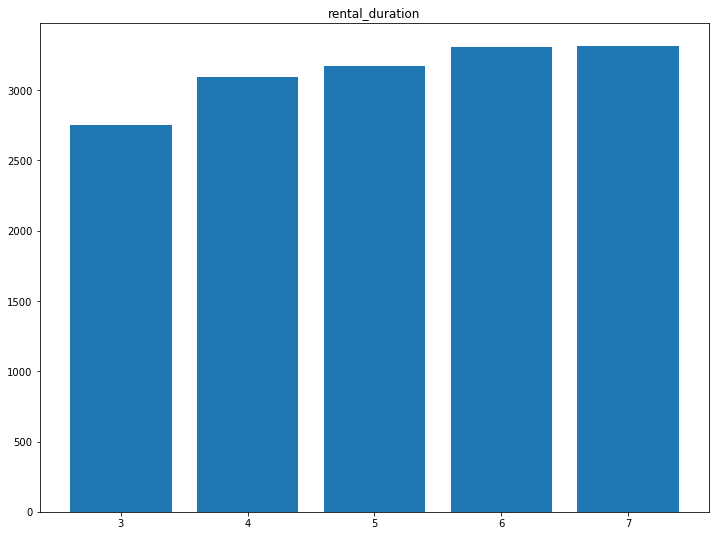

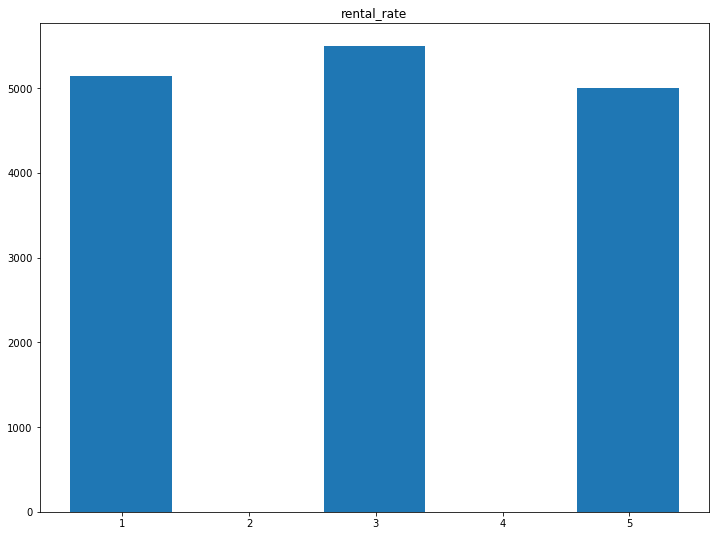

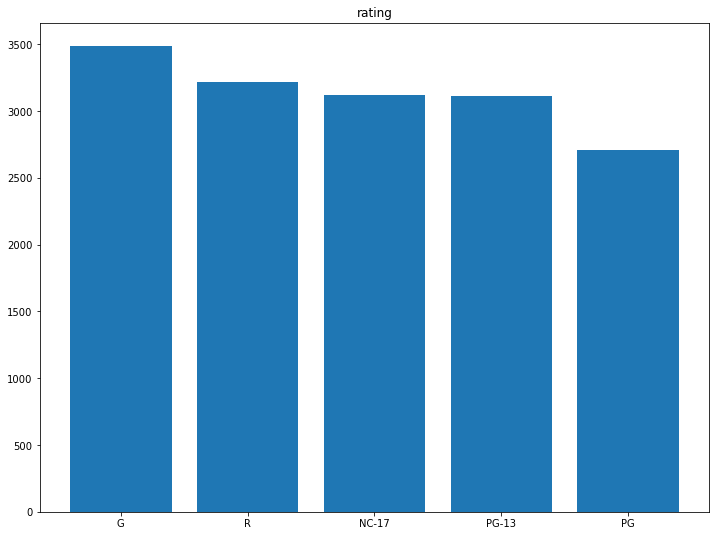

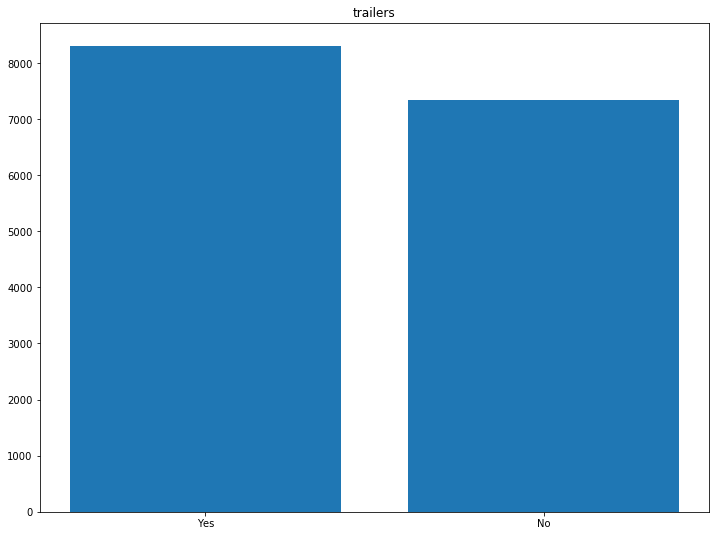

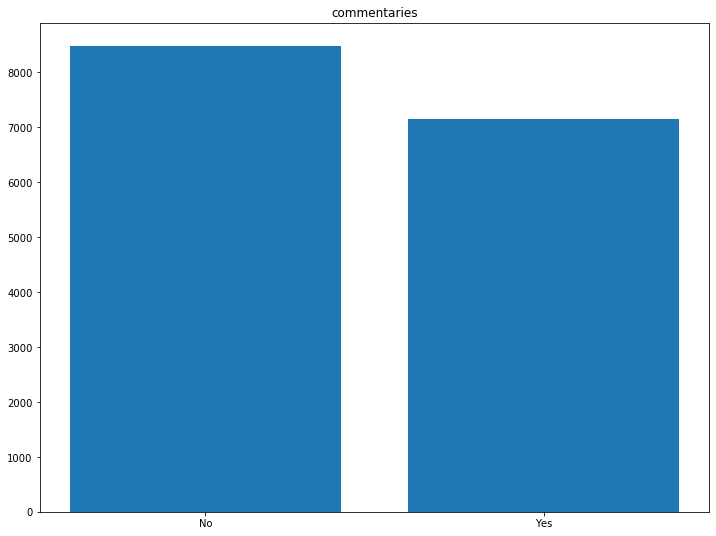

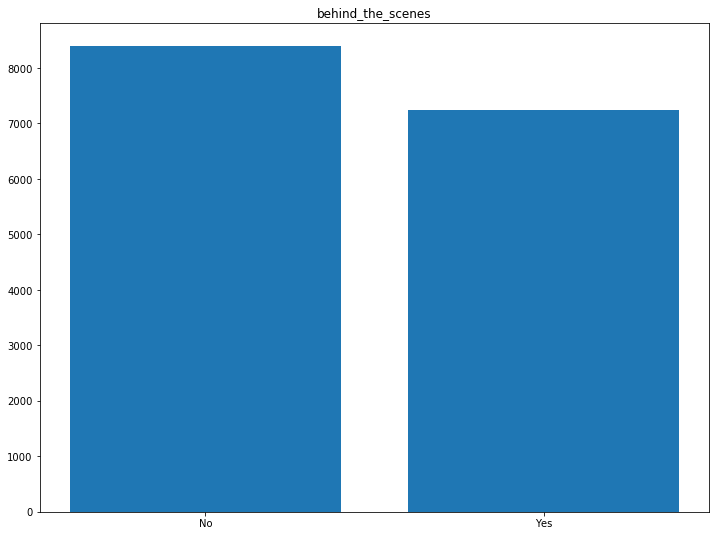

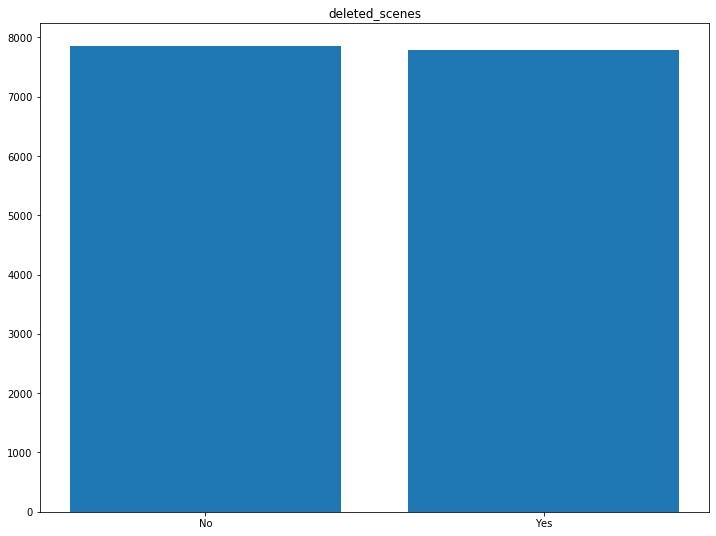

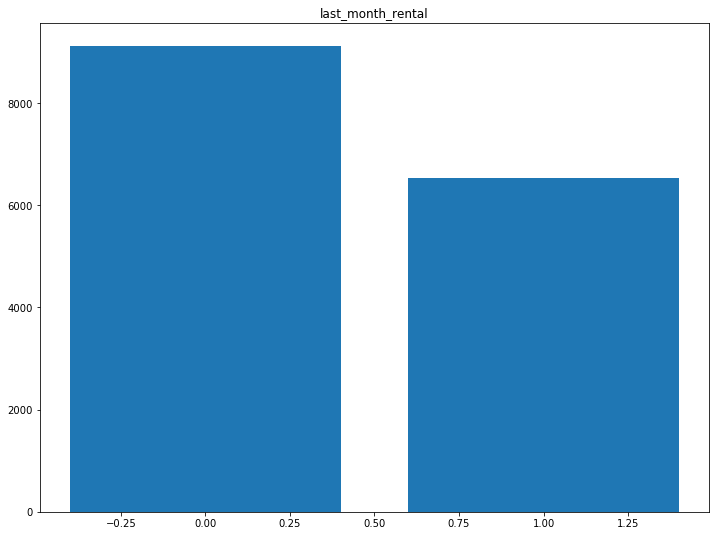

In [263]:
# Select categorical and discrete numerical data
cat_cols = []

for column in data.columns:
    if len(data[column].unique()) <= 10 or data[column].dtypes == object:
        cat_cols.append(column)

# Save bar plots for categorical data with few values
for column in cat_cols:
    x = data[column].unique()
    y = data[column].value_counts()
    if len(x) < 100:
        fig, ax = plt.subplots(figsize = (12, 9))
        plt.title(column)
        plt.bar(x, y)
        plt.show()

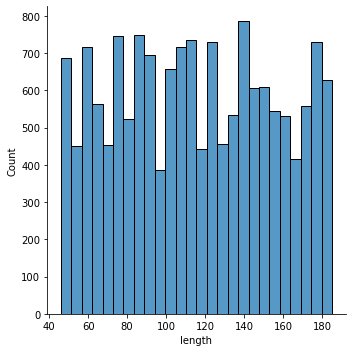

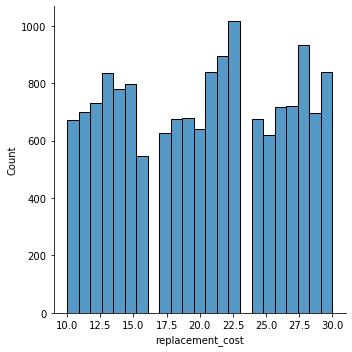

In [264]:
# Select the numerical data
num = data.select_dtypes(np.number)

# Extract the continuous numerical data and plot it
for column in num.columns:
    if len(data[column].unique()) > 10:
        sns.displot(data[column])
        plt.show()

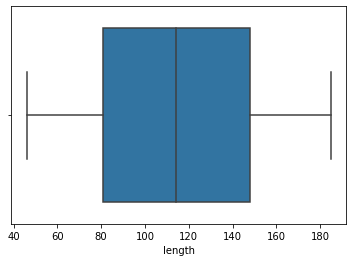

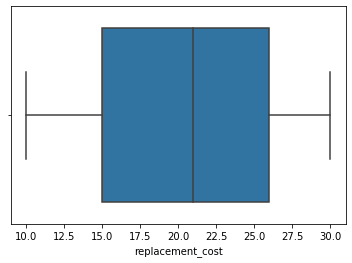

In [265]:
# Extract the continuous numerical data and plot it
for column in num.columns:
    if len(data[column].unique()) > 10:
        sns.boxplot(x=column, data=data)
        plt.show()

##### 3.1.6. Encode categorical variables and scale numerical variables.

In [266]:
# Change rental_rate & rental_duration to object types, as they're discrete \
# numerical features
data['rental_rate'] = data['rental_rate'].astype(object)
data['rental_duration'] = data['rental_duration'].astype(object)

In [267]:
X = data.select_dtypes(include=np.number)

transformer = StandardScaler().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)
x.columns = X.columns
x.head()

,length,replacement_cost
0,0.823603,0.292261
1,0.274599,-0.530180
2,1.023241,-0.859157
3,1.647109,0.292261
4,-0.773499,1.608168


In [268]:
cat = data.select_dtypes(include=object)
categorical = pd.get_dummies(cat, columns=cat.columns)

In [238]:
cat = data.select_dtypes(include=object)
cat.columns

Index(['rental_duration', 'rental_rate', 'rating', 'trailers', 'commentaries',
       'behind_the_scenes', 'deleted_scenes'],
      dtype='object')

##### 3.1.7. Create a logistic regression model.

In [269]:
# X-y split
y = data['last_month_rental']
X = np.concatenate((x, categorical), axis=1) 

In [270]:
categorical.head()

,rental_duration_3,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,...,rating_PG-13,rating_R,trailers_No,trailers_Yes,commentaries_No,commentaries_Yes,behind_the_scenes_No,behind_the_scenes_Yes,deleted_scenes_No,deleted_scenes_Yes
0,0,0,0,0,1,0,1,0,1,0,...,0,0,0,1,1,0,1,0,1,0
1,0,0,0,0,1,0,1,0,0,0,...,0,1,0,1,1,0,0,1,1,0
2,0,0,0,0,1,0,1,0,1,0,...,0,0,0,1,1,0,0,1,1,0
3,0,0,0,1,0,1,0,0,0,0,...,0,1,0,1,1,0,0,1,1,0
4,0,0,1,0,0,0,1,0,0,1,...,0,0,0,1,1,0,1,0,1,0


In [271]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, \
     test_size=0.3, random_state=100)

In [272]:
# Train data using binomial classification model
classification = LogisticRegression(random_state=0, multi_class='ovr').fit(X_train, y_train)

In [273]:
# We predict on the testing dataset
predictions = classification.predict(X_test)

##### 3.1.8. Evaluate the results.

In [286]:
score = classification.score(X_test, y_test) * 100
print(round(score, 2), "%")

58.7 %


In [274]:
pd.Series(predictions).value_counts()

False    4692
dtype: int64

In [275]:
y_test.value_counts()

False    2754
True     1938
Name: last_month_rental, dtype: int64

In [276]:
confusion_matrix(y_test, predictions)

array([[2754,    0],
       [1938,    0]])

/tmp/ipykernel_548876/1747336937.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot().xaxis.set_ticklabels(["True", "False"])
/tmp/ipykernel_548876/1747336937.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot().yaxis.set_ticklabels(["True", "False"])


[Text(0, 0.5, 'True'), Text(0, 1.5, 'False')]

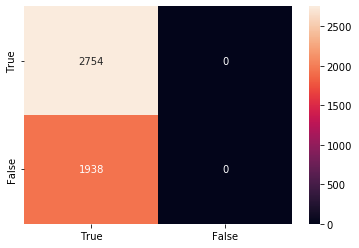

In [277]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='g')
plt.subplot().xaxis.set_ticklabels(["True", "False"])
plt.subplot().yaxis.set_ticklabels(["True", "False"])

##### 3.1.9. Check results after balancing data using TomekLinks

In [287]:
tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X, y)
y_tl.value_counts()

False    9116
True     6524
Name: last_month_rental, dtype: int64

In [288]:
X_tl2, y_tl2 = tl.fit_resample(X_tl, y_tl)
y_tl2.value_counts()

False    9111
True     6524
Name: last_month_rental, dtype: int64

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=100)
classification = LogisticRegression(random_state=0, multi_class='ovr').fit(X_train, y_train)
predictions = classification.predict(X_test)

In [290]:
score = classification.score(X_test, y_test) * 100
print(round(score, 2), "%")

58.7 %


/tmp/ipykernel_548876/4069897128.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot().xaxis.set_ticklabels(["True", "False"])
/tmp/ipykernel_548876/4069897128.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot().yaxis.set_ticklabels(["True", "False"])


[Text(0, 0.5, 'True'), Text(0, 1.5, 'False')]

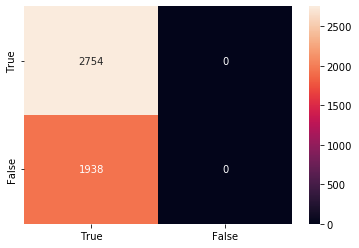

In [282]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='g')
plt.subplot().xaxis.set_ticklabels(["True", "False"])
plt.subplot().yaxis.set_ticklabels(["True", "False"])

We notice there is no difference between the performance of the model with and without the TomekLinks.